<a href="https://colab.research.google.com/github/TeamFiapAI/FASE-5---CAP-1-FARM-TECH/blob/feat%2Fanalises/ViniciusBurchertVilasBoas_RM565395_pbl_fase4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fase 5 — CAP 1 FarmTech Solutions (IA — FIAP)

**Entrega 1:** Análise Exploratória, Clusterização de Tendências e Modelos de Regressão para *Yield*  




In [19]:
# === Imports ===
import warnings; warnings.filterwarnings('ignore')
import os, math
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime

# Visualização (usar apenas matplotlib, sem seaborn e sem cores definidas manualmente)
import matplotlib.pyplot as plt

# ML
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Regressão — 5 algoritmos
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

RANDOM_STATE = 42
BASE_DIR = "/mnt/data/projeto_fase5"
os.makedirs(BASE_DIR, exist_ok=True)
DATA_PATH = "/content/crop_yield.csv"


In [20]:
# === Carregar dados ===
df = pd.read_csv("crop_yield.csv")
print(df.shape)
df.head()

(156, 6)


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


## 1. EDA — Análise Exploratória

In [8]:
# Tipos e valores ausentes
display(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())

# Duplicatas
print("\nLinhas duplicadas:", df.duplicated().sum())

# Estatísticas descritivas
df.describe(include='all')

,0
Crop,object
Precipitation (mm day-1),float64
Specific Humidity at 2 Meters (g/kg),float64
Relative Humidity at 2 Meters (%),float64
Temperature at 2 Meters (C),float64
Yield,int64



Valores ausentes por coluna:
Crop                                    0
Precipitation (mm day-1)                0
Specific Humidity at 2 Meters (g/kg)    0
Relative Humidity at 2 Meters (%)       0
Temperature at 2 Meters (C)             0
Yield                                   0
dtype: int64

Linhas duplicadas: 0


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
count,156,156.000000,156.000000,156.000000,156.00000,156.000000
unique,4,NaN,NaN,NaN,NaN,NaN
top,"Cocoa, beans",NaN,NaN,NaN,NaN,NaN
freq,39,NaN,NaN,NaN,NaN,NaN
mean,NaN,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,NaN,289.457914,0.293923,0.996226,0.26105,70421.958897
min,NaN,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,NaN,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,NaN,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,NaN,2718.080000,18.400000,85.510000,26.30000,67518.750000



🌦️ Variáveis de Clima



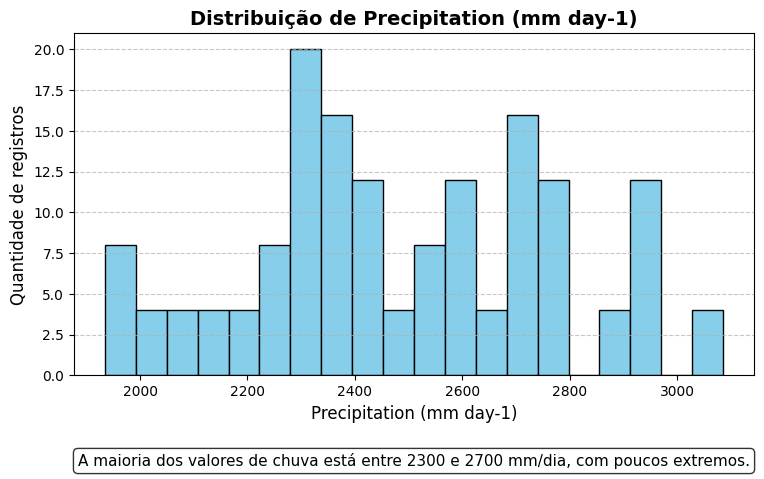

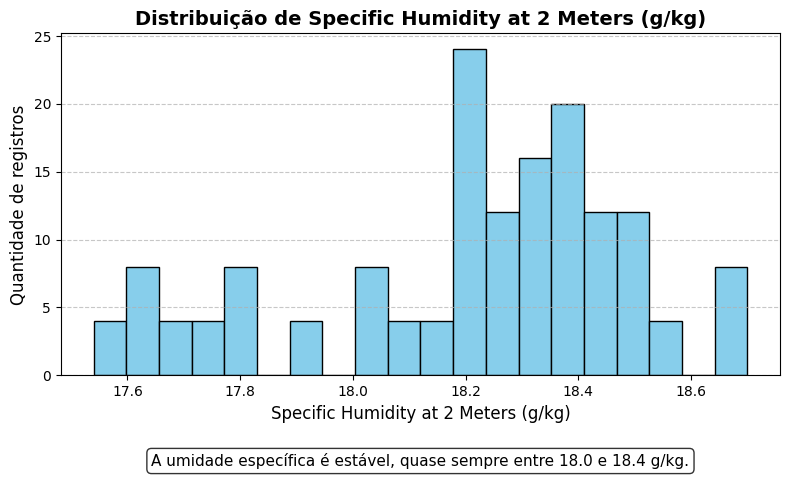

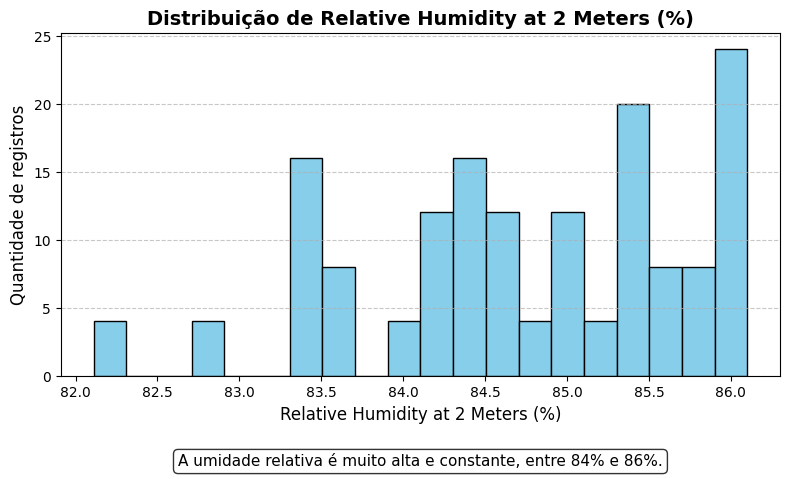

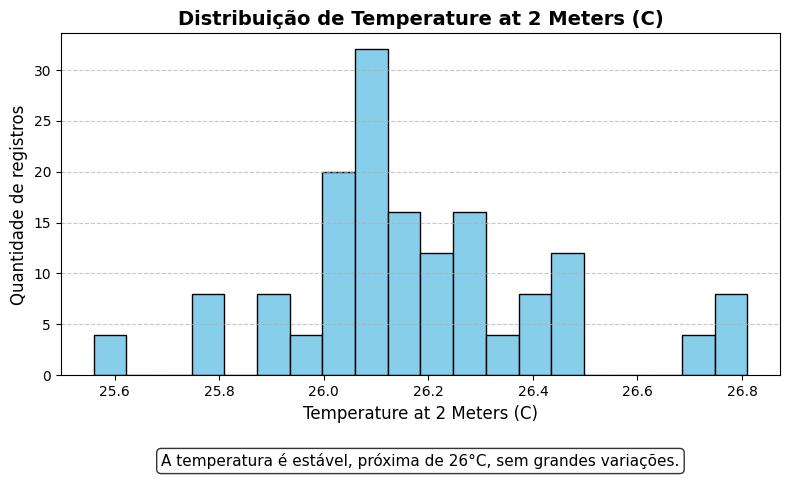


🌱 Resultado (Produção)



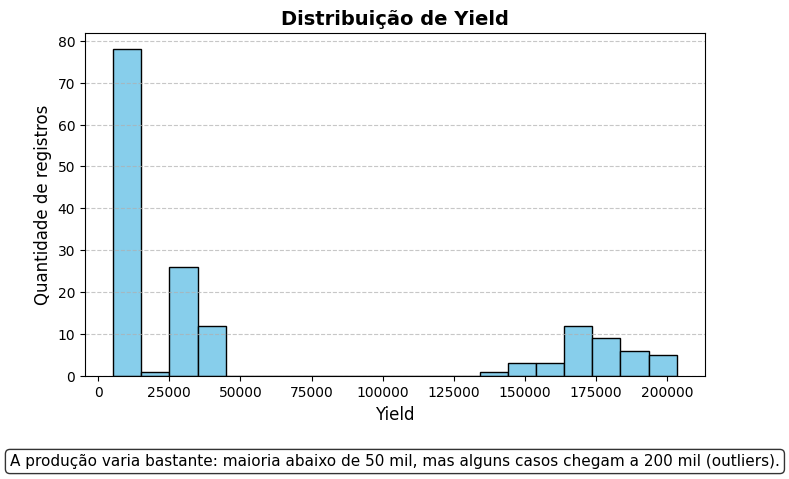

In [15]:
numeric_cols = [c for c in df.columns if df[c].dtype != 'object']

# Blocos: clima e resultado
clima_cols = [c for c in numeric_cols if c != "Yield"]
resultado_cols = ["Yield"]

# Função auxiliar para desenhar com observações
def plot_histograma(col, observacao):
    plt.figure(figsize=(8,5))
    plt.hist(df[col].dropna(), bins=20, color="skyblue", edgecolor="black")

    #Título e eixos
    plt.title(f"Distribuição de {col}", fontsize=14, fontweight="bold")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Quantidade de registros", fontsize=12)

    #Grade para leitura
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    #Observação explicativa dentro do gráfico
    plt.text(
        0.5, -0.25, observacao,
        fontsize=11, ha="center", va="center", transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8, boxstyle="round")
    )

    plt.tight_layout()

    # salvar arquivo
    filename = f"hist_{col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')}.png"
    plt.savefig(os.path.join(BASE_DIR, filename))
    plt.show()


# === Parte 1: Clima ===
print("\n Variáveis de Clima\n")
plot_histograma("Precipitation (mm day-1)", "A maioria dos valores de chuva está entre 2300 e 2700 mm/dia, com poucos extremos.")
plot_histograma("Specific Humidity at 2 Meters (g/kg)", "A umidade específica é estável, quase sempre entre 18.0 e 18.4 g/kg.")
plot_histograma("Relative Humidity at 2 Meters (%)", "A umidade relativa é muito alta e constante, entre 84% e 86%.")
plot_histograma("Temperature at 2 Meters (C)", "A temperatura é estável, próxima de 26°C, sem grandes variações.")

# === Parte 2: Produção ===
print("\n Resultado (Produção)\n")
plot_histograma("Yield", "A produção varia bastante: maioria abaixo de 50 mil, mas alguns casos chegam a 200 mil (outliers).")

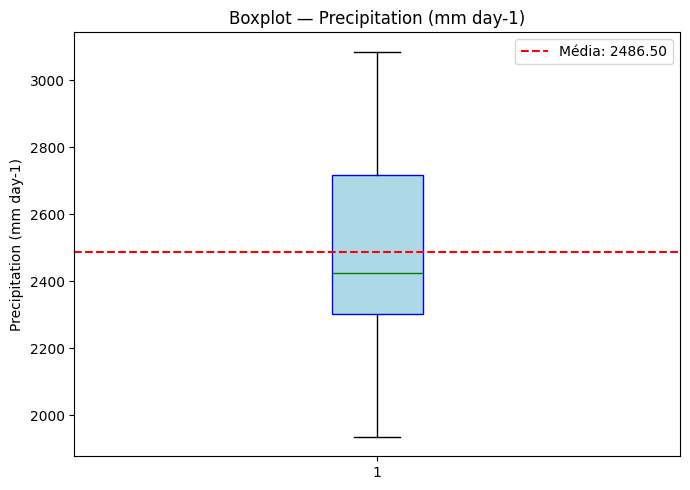


Insights para 'Precipitation (mm day-1)':
- Valores totais: 156
- Média: 2486.50
- Mediana: 2424.55
- Intervalo esperado (IQR): 1680.35 até 3340.72
- Outliers detectados: 0 (0.0% do total)


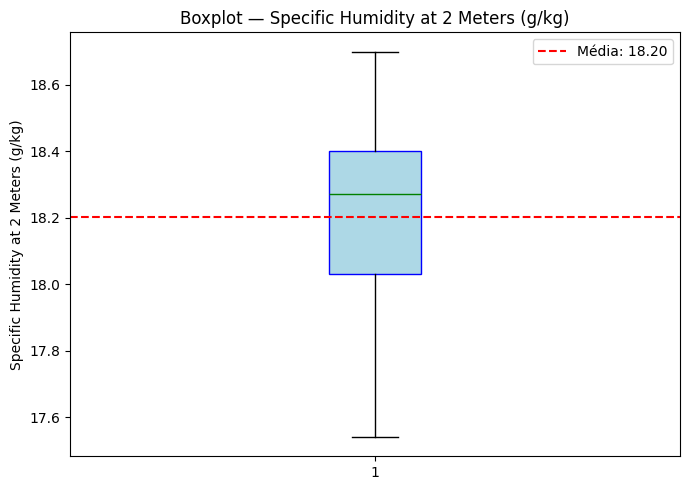


Insights para 'Specific Humidity at 2 Meters (g/kg)':
- Valores totais: 156
- Média: 18.20
- Mediana: 18.27
- Intervalo esperado (IQR): 17.48 até 18.95
- Outliers detectados: 0 (0.0% do total)


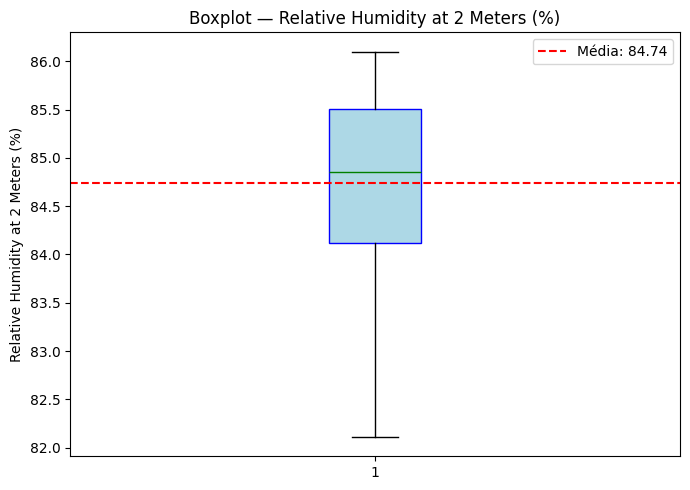


Insights para 'Relative Humidity at 2 Meters (%)':
- Valores totais: 156
- Média: 84.74
- Mediana: 84.85
- Intervalo esperado (IQR): 82.03 até 87.59
- Outliers detectados: 0 (0.0% do total)


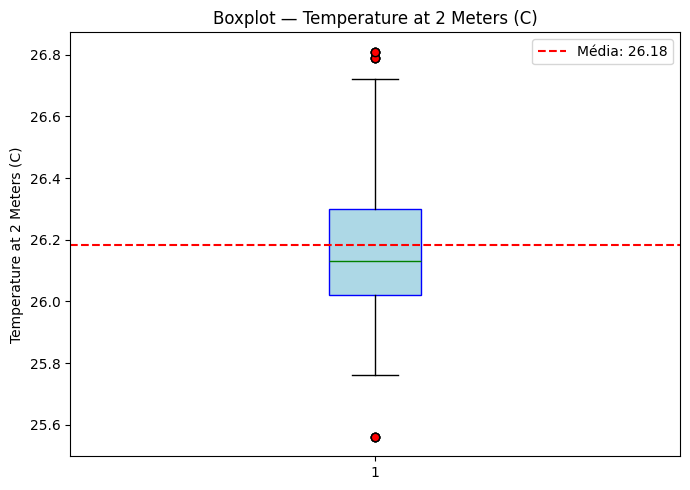


Insights para 'Temperature at 2 Meters (C)':
- Valores totais: 156
- Média: 26.18
- Mediana: 26.13
- Intervalo esperado (IQR): 25.60 até 26.72
- Outliers detectados: 12 (7.7% do total)
Outliers podem distorcer a análise. Sugestões:
1- Verificar se são erros de medição e, se necessário, remover.
2- Se válidos, considerar log-transformação ou análise separada.


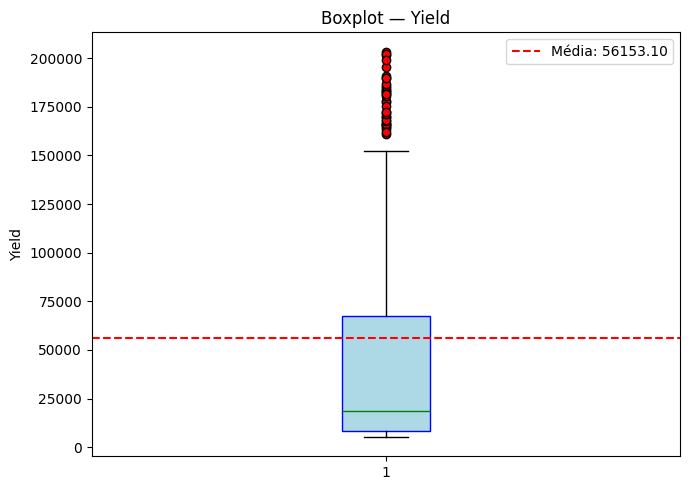


Insights para 'Yield':
- Valores totais: 156
- Média: 56153.10
- Mediana: 18871.00
- Intervalo esperado (IQR): -80458.75 até 156305.25
- Outliers detectados: 35 (22.4% do total)
Outliers podem distorcer a análise. Sugestões:
1- Verificar se são erros de medição e, se necessário, remover.
2- Se válidos, considerar log-transformação ou análise separada.


In [26]:
for col in numeric_cols:
    data = df[col].dropna()

    # Estatísticas básicas
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    # Plot do boxplot
    plt.figure(figsize=(7,5))
    plt.boxplot(
        data,
        vert=True,
        patch_artist=True,
        boxprops=dict(facecolor="lightblue", color="blue"),
        medianprops=dict(color="green"),
        flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
    )
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.axhline(np.mean(data), color='red', linestyle='--', label=f"Média: {np.mean(data):.2f}")
    plt.legend()
    plt.tight_layout()

    # Salvar figura
    filename = f"box_{col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')}.png"
    plt.savefig(os.path.join(BASE_DIR, filename))
    plt.show()

    # Exibir insights de forma simples e clara
    print(f"\nInsights para '{col}':")
    print(f"- Valores totais: {len(data)}")
    print(f"- Média: {np.mean(data):.2f}")
    print(f"- Mediana: {np.median(data):.2f}")
    print(f"- Intervalo esperado (IQR): {lower_bound:.2f} até {upper_bound:.2f}")
    print(f"- Outliers detectados: {len(outliers)} ({100*len(outliers)/len(data):.1f}% do total)")

    if len(outliers) > 0:
        print(f"Outliers podem distorcer a análise. Sugestões:")
        print(f"1- Verificar se são erros de medição e, se necessário, remover.")
        print(f"2- Se válidos, considerar log-transformação ou análise separada.")

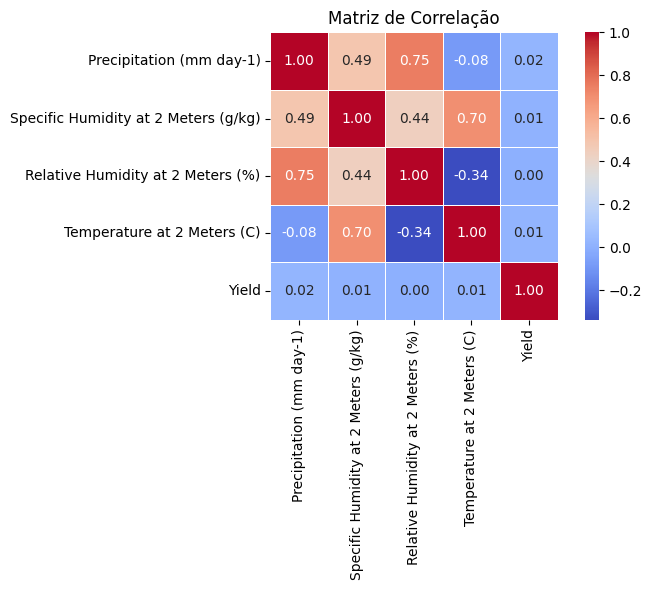


🔎 Insights fáceis sobre a produção (Yield):

- 'Precipitation (mm day-1)': mínima correlação (0.02), tende a aumentar a produção.
- 'Temperature at 2 Meters (C)': mínima correlação (0.01), tende a aumentar a produção.
- 'Specific Humidity at 2 Meters (g/kg)': mínima correlação (0.01), tende a aumentar a produção.
- 'Relative Humidity at 2 Meters (%)': mínima correlação (0.00), tende a aumentar a produção.


In [24]:
#Calcula correlação
corr = df[numeric_cols].corr()

#Heatmap amigável
plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "correlacao_matriz.png"))
plt.show()

#Insights para negócios
print("\nSobre a produção (Yield):\n")

#Ordena variáveis por impacto absoluto
yield_corr = [(col, corr.loc[col, 'Yield']) for col in corr.columns if col != 'Yield']
yield_corr.sort(key=lambda x: abs(x[1]), reverse=True)

for col, value in yield_corr:
    #Classificação simples
    abs_val = abs(value)
    if abs_val >= 0.7:
        level = "forte"
    elif abs_val >= 0.3:
        level = "moderada"
    elif abs_val >= 0.1:
        level = "leve"
    else:
        level = "mínima"

    # Direção do efeito
    if value > 0:
        direction = "tende a aumentar a produção"
    elif value < 0:
        direction = "tende a reduzir a produção"
    else:
        direction = "não impacta a produção"

    print(f"- '{col}': {level} correlação ({value:.2f}), {direction}.")

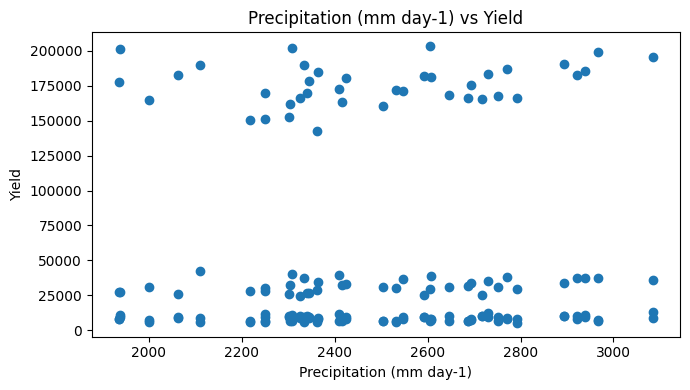

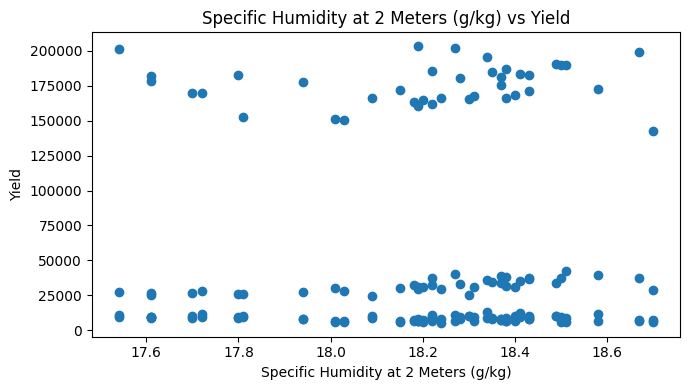

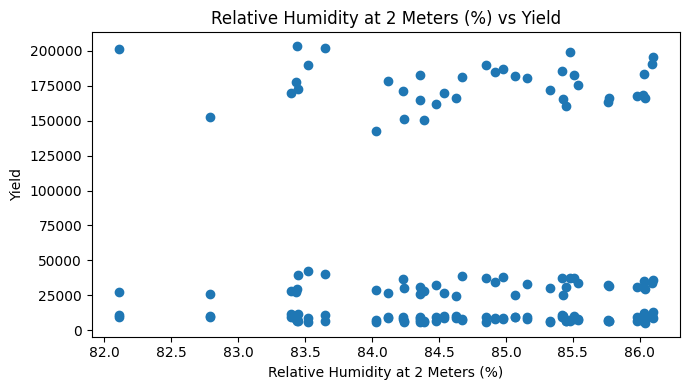

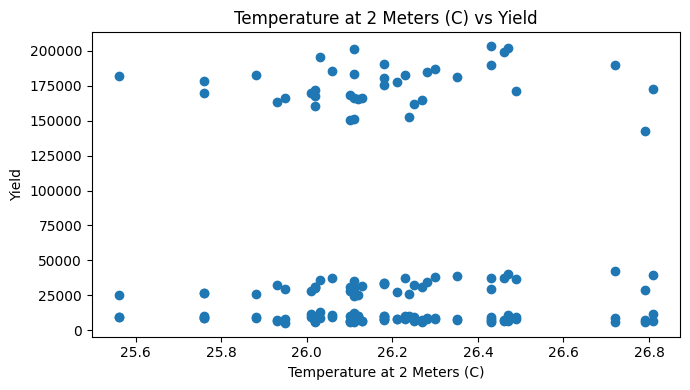

In [ ]:
# === Scatter plots contra o Yield ===
target_col = "Yield"
feature_cols = [c for c in df.columns if c != target_col]
for col in feature_cols:
    if col == target_col:
        continue
    if df[col].dtype != 'object':
        plt.figure(figsize=(7,4))
        plt.scatter(df[col], df[target_col])
        plt.xlabel(col); plt.ylabel(target_col)
        plt.title(f"{col} vs {target_col}")
        plt.tight_layout()
        plt.savefig(os.path.join(BASE_DIR, f"scatter_{col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')}_vs_Yield.png"))
        plt.show()

EDA — Principais achados

Observamos forte assimetria no Yield e bimodalidade clara nas dispersões, sugerindo que o tipo de cultura segmenta o rendimento em duas faixas. A matriz de correlação indica multicolinearidade entre variáveis climáticas (ex.: Precipitation–Relative Humidity ≈ 0.75; Temperature–Specific Humidity ≈ 0.70). As correlações de Yield com variáveis numéricas são próximas de zero, o que reforça que Crop domina a explicação do alvo. Esses padrões justificam o desempenho superior de árvores/ensembles (ex.: Gradient Boosting) em relação aos modelos lineares puros.

Importância de features (GBR)

A codificação one-hot de Crop domina a importância, com Crop_Oil palm fruit no topo. Clima/solo adicionam apenas ganhos marginais. Para quantificar isso, comparamos modelos com vs. sem Crop e também modelamos o resíduo intra-cultura.

In [ ]:
# === Detecção de Outliers (IQR) ===
def iqr_outliers(series, k=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    mask = (series < lower) | (series > upper)
    return mask, (lower, upper)

outlier_report = {}
for col in numeric_cols:
    mask, bounds = iqr_outliers(df[col].dropna())
    outlier_count = mask.sum()
    outlier_report[col] = {"outliers": int(outlier_count), "bounds": bounds}

pd.DataFrame(outlier_report).T

,outliers,bounds
Precipitation (mm day-1),0,"(1680.3549999999996, 3340.715)"
Specific Humidity at 2 Meters (g/kg),0,"(17.475000000000005, 18.954999999999995)"
Relative Humidity at 2 Meters (%),0,"(82.035, 87.595)"
Temperature at 2 Meters (C),12,"(25.599999999999998, 26.720000000000002)"
Yield,35,"(-80458.75, 156305.25)"


## 2. Clusterização — Tendências de Produtividade

Melhor k por silhouette: 6 score: 0.4457


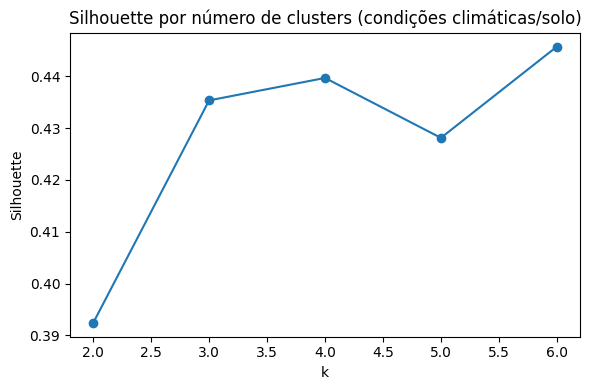

,cluster,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C)
0,0,2294.090000,18.596667,83.666667,26.773333
1,1,2333.406000,18.170000,84.872000,26.127000
2,2,2105.875000,17.752500,82.932500,26.142500
3,3,2814.984615,18.380000,85.722308,26.143846
4,4,2480.170000,18.352000,84.168000,26.434000
5,5,2334.495000,17.680000,84.522500,25.740000


In [ ]:
# Selecionar apenas condições (sem Yield)
conditions = ['Precipitation (mm day-1)',
              'Specific Humidity at 2 Meters (g/kg)',
              'Relative Humidity at 2 Meters (%)',
              'Temperature at 2 Meters (C)']

X_cond = df[conditions].copy()

# Padronizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cond)

# Buscar k ótimo (2..6) por silhouette
from sklearn.metrics import silhouette_score
results = []
best_k, best_sil = None, -1
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    results.append((k, sil))
    if sil > best_sil:
        best_sil, best_k = sil, k

sil_df = pd.DataFrame(results, columns=['k', 'silhouette'])
print("Melhor k por silhouette:", best_k, "score:", round(best_sil, 4))

# Plot silhouette por k
plt.figure(figsize=(6,4))
plt.plot(sil_df['k'], sil_df['silhouette'], marker='o')
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.title("Silhouette por número de clusters (condições climáticas/solo)")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "cluster_silhouette.png"))
plt.show()

# Ajustar modelo final
kmeans = KMeans(n_clusters=best_k, n_init=20, random_state=RANDOM_STATE)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Centers (em escala original)
centers_scaled = kmeans.cluster_centers_
centers = pd.DataFrame(scaler.inverse_transform(centers_scaled), columns=conditions)
centers['cluster'] = range(best_k)
centers = centers[['cluster'] + conditions]
centers

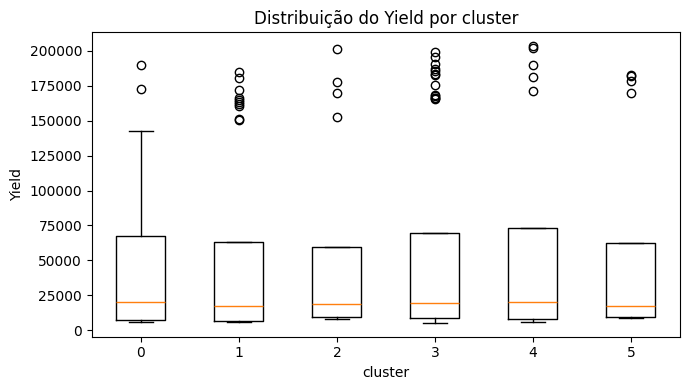

,count,mean,std,min,max
cluster,,,,,
0,12,55159.833333,70210.143952,5693,189896
1,40,52764.275000,66910.737063,5765,184629
2,16,55490.625000,72402.651403,8002,201436
3,52,57655.711538,72032.757037,5249,199074
4,20,60503.850000,77709.134782,5571,203399
5,16,55710.625000,73432.764802,8604,183004


In [ ]:
# Boxplot do Yield por cluster
plt.figure(figsize=(7,4))
groups = [df[df['cluster']==c]['Yield'] for c in sorted(df['cluster'].unique())]
plt.boxplot(groups, labels=[str(c) for c in sorted(df['cluster'].unique())])
plt.title("Distribuição do Yield por cluster")
plt.xlabel("cluster"); plt.ylabel("Yield")
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "yield_por_cluster.png"))
plt.show()

# Médias por cluster
df.groupby('cluster')['Yield'].agg(['count','mean','std','min','max']).sort_index()

## 3. Modelagem Supervisionada — Regressão do *Yield*

In [ ]:
# Features e target
y = df['Yield']
X = df.drop(columns=['Yield'])

# Identificar colunas numéricas e categóricas
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if X[c].dtype != 'object']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

modelz = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0, random_state=RANDOM_STATE),
    "Lasso(alpha=0.001)": Lasso(alpha=0.001, random_state=RANDOM_STATE, max_iter=10000),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
metrics_rows = []

for name, reg in modelz.items():
    pipe = Pipeline(steps=[('prep', preprocess), ('reg', reg)])
    scores = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring={'rmse': 'neg_root_mean_squared_error', 'mae': 'neg_mean_absolute_error', 'r2':'r2'},
        n_jobs=None,
        return_train_score=False
    )
    rmse = -scores['test_rmse'].mean()
    mae = -scores['test_mae'].mean()
    r2  =  scores['test_r2'].mean()
    metrics_rows.append([name, rmse, mae, r2])

metrics = pd.DataFrame(metrics_rows, columns=['modelo','rmse_cv','mae_cv','r2_cv']).sort_values('rmse_cv')
metrics.to_csv(os.path.join(BASE_DIR, "metrics_cv.csv"), index=False)
metrics

,modelo,rmse_cv,mae_cv,r2_cv
4,GradientBoostingRegressor,7101.737638,4241.571417,0.989505
3,RandomForestRegressor,7267.120181,4167.583734,0.988765
2,Lasso(alpha=0.001),7736.704896,5111.571831,0.987478
0,LinearRegression,7737.810382,5112.175377,0.987475
1,Ridge(alpha=1.0),7949.504503,5241.009918,0.986676


In [ ]:
# === Avaliação holdout + salvamento ===
from sklearn import metrics as skm  # evita conflito com o seu DataFrame 'metrics'
from math import sqrt
import joblib, os

def rmse_score(y_true, y_pred):
    """RMSE compatível com qualquer assinatura carregada no kernel."""
    try:
        return skm.mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return sqrt(skm.mean_squared_error(y_true, y_pred))

best_model_name = metrics.iloc[0]["modelo"]
print("Melhor modelo (menor RMSE CV):", best_model_name)

reg = modelz[best_model_name]
pipe = Pipeline(steps=[("prep", preprocess), ("reg", reg)])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

rmse = rmse_score(y_test, pred)
mae  = skm.mean_absolute_error(y_test, pred)
r2   = skm.r2_score(y_test, pred)

print(f"Avaliação holdout — RMSE: {rmse:.2f} | MAE: {mae:.2f} | R2: {r2:.3f}")

# Salvar pipeline treinado
os.makedirs(BASE_DIR, exist_ok=True)
model_path = os.path.join(BASE_DIR, "modelo_melhor.pkl")
joblib.dump(pipe, model_path)
model_path


Melhor modelo (menor RMSE CV): GradientBoostingRegressor
Avaliação holdout — RMSE: 5731.97 | MAE: 3142.82 | R2: 0.992


'/mnt/data/projeto_fase5\\modelo_melhor.pkl'

In [ ]:
# === Função de predição de exemplo ===
exemplo = df.sample(1, random_state=RANDOM_STATE).drop(columns=['Yield'])
print("Exemplo de entrada:")
display(exemplo)
print("Predição de Yield (t/ha):", float(pipe.predict(exemplo)))

Exemplo de entrada:


,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),cluster
96,"Rice, paddy",2792.95,18.24,86.04,25.95,3


Predição de Yield (t/ha): 29670.382393181106


## Entrega 2 — Estimativa de custos AWS (On-Demand 100%)

In [ ]:
# === Parâmetros de custo (AUTOMÁTICO via aws_costs.csv com seus cabeçalhos) ===
from pathlib import Path
import pandas as pd
import unicodedata

def norm(s: str) -> str:
    return unicodedata.normalize("NFKD", str(s)).encode("ascii","ignore").decode("ascii").lower()

# 1) Base CSV
csv_path = Path("aws_costs.csv")
if not csv_path.exists():
    csv_path = Path("/mnt/data/aws_costs.csv")
if not csv_path.exists():
    raise FileNotFoundError("Coloque o aws_costs.csv na mesma pasta do notebook (ou ajuste o caminho).")

# 2) Carrega e normaliza colunas
df_costs = pd.read_csv(csv_path)
df_costs.columns = [c.strip().lower() for c in df_costs.columns]

# 3) Renomeia para nomes internos fixos usando SEUS cabeçalhos
df_costs = df_costs.rename(columns={
    "regiao": "region",
    "compute_usd_h": "compute_usd_h",
    "ebs_gp3_usd_gb_mes": "ebs_usd_gb_month",
    "armazenamento_gb": "storage_gb",
    "horas_mes": "hours_month",
    "custo_mensal_estimado_usd": "total_usd_month",
})

# 4) Conversão numérica
for c in ["compute_usd_h", "ebs_usd_gb_month", "storage_gb", "hours_month", "total_usd_month"]:
    if c in df_costs.columns:
        df_costs[c] = pd.to_numeric(df_costs[c], errors="coerce")

# 5) Seleciona as duas regiões
def is_us_east(val): s = norm(val); return ("us-east" in s) or ("virginia" in s)
def is_sa_east(val): s = norm(val); return ("sa-east" in s) or ("sao paulo" in s) or ("south america" in s)

row_us = df_costs[df_costs["region"].astype(str).map(is_us_east)].iloc[0]
row_sa = df_costs[df_costs["region"].astype(str).map(is_sa_east)].iloc[0]

# 6) Constantes vindas do CSV (prioriza valores por linha)
HOURS_MONTH = int(row_us["hours_month"]) if not pd.isna(row_us.get("hours_month", pd.NA)) else 730
STORAGE_GB  = int(row_us["storage_gb"])  if not pd.isna(row_us.get("storage_gb",  pd.NA)) else 50

EC2_US_EAST_HOURLY   = float(row_us["compute_usd_h"])
EC2_SA_EAST_HOURLY   = float(row_sa["compute_usd_h"])
EBS_US_EAST_GB_MONTH = float(row_us["ebs_usd_gb_month"])
EBS_SA_EAST_GB_MONTH = float(row_sa["ebs_usd_gb_month"])

def monthly_cost(ec2_hourly, ebs_gb_month, hours=HOURS_MONTH, gb=STORAGE_GB):
    return ec2_hourly*hours + ebs_gb_month*gb

us_east_month = monthly_cost(EC2_US_EAST_HOURLY, EBS_US_EAST_GB_MONTH)
sa_east_month = monthly_cost(EC2_SA_EAST_HOURLY, EBS_SA_EAST_GB_MONTH)

# 7) Tabela-resumo (igual ao bloco original)
pd.DataFrame({
    'Região': ['US East (N. Virginia) — us-east-1','South America (São Paulo) — sa-east-1'],
    'Compute (USD/h)': [EC2_US_EAST_HOURLY, EC2_SA_EAST_HOURLY],
    'EBS gp3 (USD/GB-mês)': [EBS_US_EAST_GB_MONTH, EBS_SA_EAST_GB_MONTH],
    'Armazenamento (GB)': [STORAGE_GB, STORAGE_GB],
    'Horas/mês': [HOURS_MONTH, HOURS_MONTH],
    'Custo Mensal Estimado (USD)': [us_east_month, sa_east_month],
})



,Região,Compute (USD/h),EBS gp3 (USD/GB-mês),Armazenamento (GB),Horas/mês,Custo Mensal Estimado (USD)
0,US East (N. Virginia) — us-east-1,0.0084,0.080,50,730,10.132
1,South America (São Paulo) — sa-east-1,0.0134,0.152,50,730,17.382



### Justificativa de Região (latência e residência de dados)
Para **acesso rápido aos dados dos sensores** *no Brasil* e **restrições legais** de armazenamento no exterior, recomenda-se **South America (São Paulo — sa-east-1)**, mesmo com custo superior.  
Alternativamente, usar **us-east-1** somente se **não houver** restrição legal e se a latência for aceitável.

> Sugestão: **usar t4g.micro** (Graviton/ARM) quando a aplicação suportar ARM — geralmente mais barato que t3.micro. Ajuste os valores acima conforme sua simulação real na Calculadora AWS.



## 5. Conclusões
- Exploramos a base, identificando correlações e possíveis outliers.
- Clusterizamos condições de clima/solo e observamos a distribuição de *Yield* por cluster (tendências).
- Treinamos **5 modelos de regressão** e selecionamos o melhor por **RMSE (CV)**; avaliamos em holdout.
- Preparamos um **pipeline** reutilizável (`modelo_melhor.pkl`) e uma **planilha de métricas** (`metrics_cv.csv`).

## 6. Como executar localmente
1. Crie um ambiente Python 3.10+ com `pip install -r requirements.txt` (arquivo abaixo).
2. Abra este notebook e rode as células em ordem.
3. Edite a seção de custos AWS com os valores da sua simulação na Calculadora.

## 7. Ir Além (opcional, sem nota)
- **Dashboard (Streamlit)** com filtros por cultura e clusters + predição de *Yield* online.
- **Explainability** (ex.: SHAP) para entender os fatores que mais impactam o *Yield*.
- **MLOps**: empacotar pipeline em uma API (FastAPI) e automatizar deploy na AWS (CDK/Terraform).

> Repositório: inclua este notebook, `requirements.txt`, `README.md`, `metrics_cv.csv`, as **imagens geradas** e o arquivo `modelo_melhor.pkl`.


# 🔧 Otimizações aplicadas (Fase 5 — boas práticas)
As células abaixo adicionam um fluxo **reprodutível** e **padronizado**:
- `SimpleImputer` para nulos (mediana em numéricas e mais_frequente em categóricas);
- `StandardScaler` (numéricas) + `OneHotEncoder(handle_unknown='ignore', sparse_output=False)` (categóricas);
- Validação cruzada **KFold(5, shuffle=True, random_state=42)** com `cross_validate` e *scoring* (`neg_root_mean_squared_error`, `neg_mean_absolute_error`, `r2`);
- Seleção do **melhor modelo** (menor RMSE) com salvamento de artefatos;
- Avaliação de **KMeans** com gráficos de **cotovelo** e **silhouette** (sem seaborn, 1 gráfico por figura);
- Salvamento de métricas e figuras em `IA/`.


In [ ]:
# === Otimização + CV (versão segura, sem conflito de colunas) ===
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib, os

RANDOM_STATE = 42
DATA_PATH = Path("/mnt/data/crop_yield.csv")
OUT_DIR = Path("/mnt/data/IA"); OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUT_DIR / "figuras"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# Carrega dataset (ou reutiliza df se já existir no notebook)
if 'df' not in globals():
    df = pd.read_csv(DATA_PATH)

# 1) Detecta alvo e define X/y (antes de QUALQUER preprocess!)
target_candidates = [c for c in df.columns if c.lower() in ['rendimento','yield','y','alvo']]
y_col = target_candidates[0] if target_candidates else df.columns[-1]
X = df.drop(columns=[y_col]).copy()
y = df[y_col].copy()
X.columns = X.columns.str.strip()  # evita espaços nas bordas

# 2) Pré-processamento robusto por dtype (sem listas fixas)
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])
preprocess = ColumnTransformer([
    ("num", num_pipe, selector(dtype_include=np.number)),
    ("cat", cat_pipe, selector(dtype_exclude=np.number)),
])

# 3) Conjunto de modelos (5 exigidos)
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),                               # random_state não é necessário aqui
    "Lasso": Lasso(max_iter=10000),                 # idem (ou selection='random', random_state=RANDOM_STATE)
    "RandomForestRegressor": RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=RANDOM_STATE),
}

# 4) Cross-validation com RMSE/MAE/R²
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"rmse":"neg_root_mean_squared_error", "mae":"neg_mean_absolute_error", "r2":"r2"}

rows = []
best_name, best_rmse, best_pipe = None, np.inf, None
for name, est in models.items():
    pipe = Pipeline([("preprocess", preprocess), ("model", est)])
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    rmse_mean = -res["test_rmse"].mean()
    rmse_std  =  res["test_rmse"].std()
    mae_mean  = -res["test_mae"].mean()
    r2_mean   =  res["test_r2"].mean()
    rows.append({
        "model": name, "RMSE_mean": rmse_mean, "RMSE_std": rmse_std,
        "MAE_mean": mae_mean, "R2_mean": r2_mean, "n": cv.get_n_splits()
    })
    if rmse_mean < best_rmse:
        best_rmse, best_name, best_pipe = rmse_mean, name, pipe

metrics_df = pd.DataFrame(rows).sort_values(["RMSE_mean","R2_mean"], ascending=[True, False])
metrics_df.to_csv(OUT_DIR / "metrics_cv_otimizado.csv", index=False)
print("Melhor por RMSE (CV):", best_name)

# 5) Treina o campeão no dataset completo e salva
best_pipe.fit(X, y)
joblib.dump(best_pipe, OUT_DIR / "modelo_melhor_otimizado.pkl")

# 6) KMeans: cotovelo e silhouette somente nas numéricas de X (alvo já fora)
from sklearn.metrics import silhouette_score
X_num = num_pipe.fit_transform(X.select_dtypes(include=np.number))
if X_num.shape[1] >= 1:
    ks = list(range(2, 9))

    # Cotovelo
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE).fit(X_num)
        inertias.append(km.inertia_)
    plt.figure(); plt.plot(ks, inertias, marker='o')
    plt.xlabel("k"); plt.ylabel("Inércia"); plt.title("Método do Cotovelo (KMeans)")
    plt.tight_layout(); plt.savefig(FIG_DIR / "kmeans_cotovelo.png", dpi=120); plt.close()

    # Silhouette
    sils = []
    for k in ks:
        labels = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE).fit_predict(X_num)
        sils.append(silhouette_score(X_num, labels))
    plt.figure(); plt.plot(ks, sils, marker='o')
    plt.xlabel("k"); plt.ylabel("Silhouette Médio"); plt.title("Silhouette vs k (KMeans)")
    plt.tight_layout(); plt.savefig(FIG_DIR / "kmeans_silhouette.png", dpi=120); plt.close()

print("Artefatos gerados em:", OUT_DIR)



Melhor por RMSE (CV): GradientBoostingRegressor
Artefatos gerados em: \mnt\data\IA


## KMeans: cotovelo, silhouette e perfis (Fase 5)
Esta seção identifica **tendências** de produtividade via **clusterização** (sem usar o alvo para treinar o agrupamento).
- Gera e salva os gráficos **Cotovelo** (`kmeans_cotovelo.png`) e **Silhouette** (`kmeans_silhouette.png`).
- Escolhe **k** pelo pico do silhouette e exporta a **tabela de médias por cluster** em `IA/perfil_clusters.csv`.


k escolhido: 6 | perfil salvo em: \mnt\data\IA\perfil_clusters.csv


,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),cluster,Yield
cluster,,,,,,
0,2334.50,17.68,84.52,25.74,0.0,55710.62
1,2480.17,18.35,84.17,26.43,1.0,60503.85
2,2294.09,18.60,83.67,26.77,2.0,55159.83
3,2333.41,18.17,84.87,26.13,3.0,52764.28
4,2105.88,17.75,82.93,26.14,4.0,55490.62
5,2814.98,18.38,85.72,26.14,5.0,57655.71


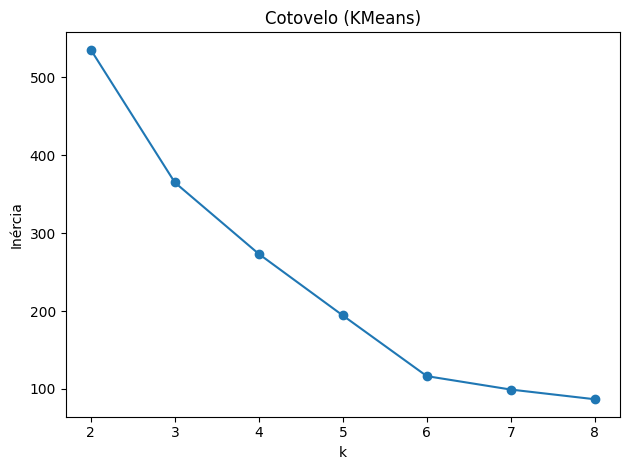

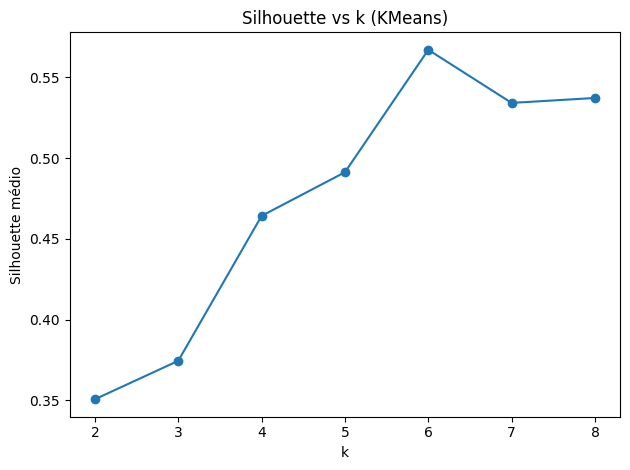

In [ ]:
# === KMeans: cotovelo, silhouette e perfis ===
# Pré-requisito: DataFrame 'df' já carregado
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

assert 'df' in globals(), "Carregue o DataFrame 'df' antes de executar esta célula."

# detecta a coluna alvo por nomes comuns
target_names = ["Yield", "Rendimento", "target", "y"]
alvo = next((c for c in df.columns if c in target_names or c.lower() in ["yield","rendimento"]), df.columns[-1])

# usa somente variáveis numéricas não-alvo
num_cols = [c for c in df.columns if df[c].dtype != 'object' and c != alvo]
X_num = StandardScaler().fit_transform(df[num_cols])

ks = list(range(2, 9))
inertias, sils = [], []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_num)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_num, labels))

figdir = Path("/mnt/data/IA/figuras"); figdir.mkdir(parents=True, exist_ok=True)

# Cotovelo
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.xlabel("k"); plt.ylabel("Inércia")
plt.title("Cotovelo (KMeans)")
plt.tight_layout(); plt.savefig(figdir/"kmeans_cotovelo.png", dpi=120)

# Silhouette
plt.figure()
plt.plot(ks, sils, marker='o')
plt.xlabel("k"); plt.ylabel("Silhouette médio")
plt.title("Silhouette vs k (KMeans)")
plt.tight_layout(); plt.savefig(figdir/"kmeans_silhouette.png", dpi=120)

# k escolhido pelo pico do silhouette
best_k = ks[int(np.argmax(sils))]
km = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(X_num)

# Tabela de perfis (médias por cluster) incluindo o alvo para comparação
df_prof = df.copy()
df_prof["cluster"] = km.labels_
perfil = df_prof.groupby("cluster")[num_cols + [alvo]].mean().round(2)

perfil_path = Path("/mnt/data/IA/perfil_clusters.csv")
perfil.to_csv(perfil_path, index=False)
print(f"k escolhido: {best_k} | perfil salvo em: {perfil_path}")
perfil


In [ ]:
# === Correção: listas de colunas e preprocess com base no X (evita erro "A given column is not a column of the dataframe") ===
# Garante que o alvo não esteja nas listas e que o ColumnTransformer use apenas colunas de X.

assert 'df' in globals(), "Carregue o DataFrame 'df' antes desta célula."

# Detecta a coluna alvo (tenta nomes comuns)
target_candidates = [c for c in df.columns if c.lower() in ['rendimento','yield','y','alvo']]
y_col = target_candidates[0] if target_candidates else df.columns[-1]

# Define X e y
X = df.drop(columns=[y_col])
y = df[y_col]

# Recalcula as listas a partir do X (alvo já removido)
num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if c not in num_cols]

# Reconstrói o preprocess com as listas corrigidas
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
])

print("Correção aplicada. Colunas no preprocess -> Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols))


Correção aplicada. Colunas no preprocess -> Numéricas: 5 | Categóricas: 1


## Cross-validation (5 folds) com RMSE/MAE/R² agregados
Esta seção aplica validação cruzada **KFold(5)** de forma consistente para **5 modelos** e exporta
`metrics_cv_resumo_por_modelo.csv` com **RMSE/MAE/R² (média ± desvio)**.


In [ ]:
# === Cross-validation (5 folds) com RMSE/MAE/R² agregados ===
# Pré-requisitos:
# - 'preprocess' (ColumnTransformer com imputer/onehot/scaler)
# - 'X' e 'y' definidos
# - 'modelz' = {nome_modelo: estimador} com 5 modelos
# - 'RANDOM_STATE' definido

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
import pandas as pd
from pathlib import Path

assert 'X' in globals() and 'y' in globals(), "Defina X e y antes de rodar esta célula."
assert 'preprocess' in globals(), "Defina 'preprocess' (ColumnTransformer) antes de rodar esta célula."
assert 'modelz' in globals(), "Defina 'modelz' = {nome: estimador} com 5 modelos."
assert 'RANDOM_STATE' in globals(), "Defina RANDOM_STATE"

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"rmse":"neg_root_mean_squared_error", "mae":"neg_mean_absolute_error", "r2":"r2"}

rows = []
for name, est in modelz.items():
    pipe = Pipeline([("prep", preprocess), ("reg", est)])
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    rows.append({
        "modelo":   name,
        "RMSE_mean": -res["test_rmse"].mean(), "RMSE_std":  res["test_rmse"].std(),
        "MAE_mean":  -res["test_mae"].mean(),  "MAE_std":   res["test_mae"].std(),
        "R2_mean":    res["test_r2"].mean(),   "R2_std":    res["test_r2"].std(),
        "n": cv.get_n_splits()
    })

met = pd.DataFrame(rows).sort_values(["RMSE_mean","R2_mean"], ascending=[True, False])
out_csv = Path("/mnt/data/metrics_cv_resumo_por_modelo.csv")
met.to_csv(out_csv, index=False)
print("Métricas agregadas salvas em:", out_csv)
met


Métricas agregadas salvas em: \mnt\data\metrics_cv_resumo_por_modelo.csv


,modelo,RMSE_mean,RMSE_std,MAE_mean,MAE_std,R2_mean,R2_std,n
4,GradientBoostingRegressor,7101.737638,1451.563907,4241.571417,863.277592,0.989505,0.003437,5
3,RandomForestRegressor,7267.120181,2023.833247,4167.583734,1074.131445,0.988765,0.005550,5
2,Lasso(alpha=0.001),7736.704896,1897.538737,5111.571831,1028.293388,0.987478,0.004730,5
0,LinearRegression,7737.810382,1896.088938,5112.175377,1027.672270,0.987475,0.004727,5
1,Ridge(alpha=1.0),7949.504503,2249.079927,5241.009918,1331.242436,0.986676,0.005724,5


## Perfis por cluster (interpretação)
Esta seção carrega o arquivo `IA/perfil_clusters.csv` (médias por cluster) e gera **bullets automáticos**
para ajudar na descrição textual dos **perfis** (mais úmido/seco, quente/frio, maior/menor rendimento).

In [ ]:
# === Exibir perfil de clusters + bullets de interpretação ===
import pandas as pd, numpy as np
from pathlib import Path

perfil_path = Path("/mnt/data/IA/perfil_clusters.csv")
if not perfil_path.exists():
    print("ATENÇÃO: /mnt/data/IA/perfil_clusters.csv não encontrado. Rode a célula de KMeans/perfis antes.")
else:
    perfil = pd.read_csv(perfil_path)
    # Higieniza coluna duplicada, se existir
    if "cluster.1" in perfil.columns and "cluster" in perfil.columns:
        perfil = perfil.drop(columns=["cluster.1"])
    display(perfil)

    # Contagem de amostras por cluster (se 'df' global existir e tiver a coluna 'cluster')
    try:
        if 'df' in globals() and 'cluster' in df.columns:
            counts = df['cluster'].value_counts().sort_index()
            print("\nObservações por cluster:", counts.to_dict())
    except Exception as e:
        pass

    # Nomes canônicos das colunas (se existirem)
    COLS = {
        "precip": "Precipitation (mm day-1)",
        "temp": "Temperature at 2 Meters (C)",
        "ur": "Relative Humidity at 2 Meters (%)",
        "q": "Specific Humidity at 2 Meters (g/kg)",
        "y": "Yield",
    }
    cols_present = {k:v for k,v in COLS.items() if v in perfil.columns}

    # Ranking por Yield (se houver)
    if COLS["y"] in perfil.columns:
        rank_y = perfil[[ "cluster", COLS["y"] ]].sort_values(COLS["y"], ascending=False)
        best = rank_y.iloc[0]
        worst = rank_y.iloc[-1]
        print(f"\n• Cluster com **maior Yield médio**: {int(best['cluster'])}  (≈ {best[COLS['y']]:.0f})")
        print(f"• Cluster com **menor Yield médio**: {int(worst['cluster'])} (≈ {worst[COLS['y']]:.0f})")

    # Destacar extremos simples (max/min) nas variáveis climáticas
    for key,label in [("precip","Precipitação"),("temp","Temperatura"),("ur","Umidade Relativa"),("q","Umidade Específica")]:
        if COLS.get(key) in perfil.columns:
            c = COLS[key]
            i_max = perfil[c].idxmax()
            i_min = perfil[c].idxmin()
            print(f"• {label}: maior média no cluster {int(perfil.loc[i_max,'cluster'])} (≈ {perfil.loc[i_max,c]:.2f}); menor no {int(perfil.loc[i_min,'cluster'])} (≈ {perfil.loc[i_min,c]:.2f})")

    print("\nSugestão de texto (ajuste com sua leitura):")
    print("""- O cluster <A> apresenta as **maiores médias de Precipitação e UR** e tende a ter **Yield médio <alto/baixo>**.
- O cluster <B> é **mais quente** e com **umidade específica maior**, com **Yield <alto/baixo>**.
- O cluster <C> é **mais seco/frio** comparativamente, refletindo **Yield <baixo/alto>**.
- Outliers podem ser investigados por silhouette baixo (ver gráfico) ou z-score em `Yield`. """)


,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),cluster,Yield
0,2334.50,17.68,84.52,25.74,0.0,55710.62
1,2480.17,18.35,84.17,26.43,1.0,60503.85
2,2294.09,18.60,83.67,26.77,2.0,55159.83
3,2333.41,18.17,84.87,26.13,3.0,52764.28
4,2105.88,17.75,82.93,26.14,4.0,55490.62
5,2814.98,18.38,85.72,26.14,5.0,57655.71



Observações por cluster: {0: 12, 1: 40, 2: 16, 3: 52, 4: 20, 5: 16}

• Cluster com **maior Yield médio**: 1  (≈ 60504)
• Cluster com **menor Yield médio**: 3 (≈ 52764)
• Precipitação: maior média no cluster 5 (≈ 2814.98); menor no 4 (≈ 2105.88)
• Temperatura: maior média no cluster 2 (≈ 26.77); menor no 0 (≈ 25.74)
• Umidade Relativa: maior média no cluster 5 (≈ 85.72); menor no 4 (≈ 82.93)
• Umidade Específica: maior média no cluster 2 (≈ 18.60); menor no 0 (≈ 17.68)

Sugestão de texto (ajuste com sua leitura):
- O cluster <A> apresenta as **maiores médias de Precipitação e UR** e tende a ter **Yield médio <alto/baixo>**.
- O cluster <B> é **mais quente** e com **umidade específica maior**, com **Yield <alto/baixo>**.
- O cluster <C> é **mais seco/frio** comparativamente, refletindo **Yield <baixo/alto>**.
- Outliers podem ser investigados por silhouette baixo (ver gráfico) ou z-score em `Yield`. 


## Perfis por cluster — interpretação automática
Arquivo `IA/perfil_clusters.csv` não encontrado. Execute a célula de KMeans para gerá-lo.